<a href="https://colab.research.google.com/github/t-willi/Simula/blob/main/AE_V8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer 
import glob
import torch.optim as optim
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
from tqdm.auto import tqdm
import requests
import zipfile
from pathlib import Path
!pip install ecg_plot
!pip install wandb -Uq
!pip install -Uqq ipdb
import ipdb


if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.3 MB/s 
     |████████████████████████████████| 182 kB 54.9 MB/s 
     |████████████████████████████████| 166 kB 54.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 62.9 MB/s 
     |████████████████████████████████| 162 kB 72.1 MB/s 
     |████████████████████████████████| 162 kB 68.7 MB/s 
     |████████████████████████████████| 158 kB 72.1 MB/s 
     |████████████████████████████████| 157 kB 70.1 MB/s 
     |████████████████████████████████| 157 kB 58.4 MB/s 
     |████████████████████████████████| 157 kB 56.6 MB/s 
     |████████████████████████████████| 157 kB 57.4 MB/s 
     |████████████████████████████████| 157 kB 55.6 MB/s 
     |████████████████████████████████| 157 kB 56.3 MB/s 
     |████████████████████████████████| 157 kB 55.7 MB/s 
     |████████████████████████████

In [2]:
def request(path=None,name=None):
  import requests
  from pathlib import Path
  request = requests.get(path)
  name=name+".py"
  with open(name,"wb") as f:
    f.write(request.content)

In [3]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
def unzip(path=None):
  # Setup path to data folder
  data_path = Path("data/")
  train_path = data_path / "train_data"
  # If the image folder doesn't exist, download it and prepare it... 
  if train_path.is_dir():
      print(f"{train_path} directory exists.")
  else:
      print(f"Did not find {train_path} directory, creating one...")
      train_path.mkdir(parents=True, exist_ok=True)
      # Unzip pizza, steak, sushi data
      with zipfile.ZipFile("/content/artifacts/ecg_25000.zip:v0/ecg_25000.zip", "r") as zip_ref:
          print(f"Unzipping data to folder...") 
          zip_ref.extractall(train_path)

In [5]:
## Load Custom dataloader
Dataloader_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/Dataloader.py"
request(Dataloader_git_dir,"Dataloader")
from Dataloader import Custom_dataset as CD

def make_loader(dataset,batch_size):
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      drop_last=True
                      )
  return loader

In [6]:
#Download and instantialize model
model_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/Networks.py"
request(model_git_dir,"Networks")
from Networks import ECG_AE_v1
model=ECG_AE_v1()
model

ECG_AE_v1(
  (encoder): Sequential(
    (0): Linear(in_features=5000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=20, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=35000, bias=True)
  )
)

In [23]:
#download prediction generator
get_pred_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/get_predictions.py"
request(get_pred_git_dir,"get_predictions")
from get_predictions import get_pred
#download ECG plotter
# plt_ECG_git_dir="https://raw.githubusercontent.com/t-willi/NeuralNetworks/main/plot_ECG.py"
# request(plt_ECG_git_dir,"plot_ECG")
# from plot_ECG import plotECG
# #input,output=get_pred(dataset=val_dataset,model=model)

In [9]:
# 🐝 initialise a wandb run
config = dict(
    epochs=51,
    batch_size=32,
    learning_rate=0.001,)


In [10]:
def model_pipeline(hyperparameters,model=model):
    # tell wandb to get started
    artifact = wandb.init(project="pytorch-demo", config=hyperparameters).use_artifact('ecg_simula/setup_weights and biases/ecg_25000.zip:v0', type='raw_data')
    artifact_dir = artifact.download()
    unzip()
    # access all HPs through wandb.config, so logging matches execution!
    config = wandb.config
    # make the model, data, and optimization problem
    train_loader, val_loader, criterion, optimizer,val_dataset = make(config)
    # and use them to train the model
    train(model, train_loader,val_loader, criterion, optimizer,val_dataset,config)
    return model

In [11]:
def make(config):
    # Make the data
    data_dir="/content/data/train_data"
    train_dataset = CD(data_dir=data_dir,split=True,target="train")
    val_dataset = CD(data_dir=data_dir,split=True,target="val")
    train_loader = make_loader(train_dataset, batch_size=config.batch_size)
    val_loader = make_loader(val_dataset, batch_size=config.batch_size)

    # Make the loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    return train_loader, val_loader, criterion, optimizer,val_dataset

In [53]:
def train(model, train_loader,val_loader, criterion, optimizer,val_dataset, config):
  # Tell wandb to watch what the model gets up to: gradients, weights, and more!
  wandb.watch(model, criterion, log="all")
  for epoch in tqdm(range(config.epochs)):
    train_loss=0
    for batch,(X,y) in tqdm(enumerate(train_loader)):
      # Forward pass ➡
      X, y = X.to(device), y.to(device) 
      model.train()
      output=model(X)
      output=torch.reshape(output,(config.batch_size, 1, 7, 5000))
      loss = criterion(output,y)
      train_loss += loss
      # Backward pass ⬅
      optimizer.zero_grad()
      loss.backward()
      # Step with optimizer
      optimizer.step()
      if batch == 5:
        break
    #average loss per batch
    train_loss /= len(train_loader)


    val_loss = 0
    model.eval()
    with torch.inference_mode():
      for batch,(X,y) in enumerate(val_loader):
        #print("doing test loop")
        X, y = X.to(device), y.to(device)
        val_pred = model(X)
        val_pred=torch.reshape(val_pred,(config.batch_size, 1, 7, 5000))
        loss=criterion(val_pred,y)
        val_loss += loss
        if batch == 5:
          break
      val_loss /= len(val_loader)  
      wandb.log({"train_loss": train_loss, 
                 "val_loss": val_loss})
      

    if epoch % 25==0:
      #setup folder for outputs
      ecg_path=Path("/content/ECG/")
      if ecg_path.is_dir():
        print("Folder exists")
      else:
        ecg_path.mkdir()
      df_input,df_output=get_pred(val_dataset,model)
      combined_df=plotECG(df_input,df_output,path="/content/ECG/")
      png_to_jpg()
      wandb.log({"ECG": wandb.Image("/content/ECG/ECG.jpg")})
      
    #if epoch % 1==0:
    # #Save the model in the exchangeable ONNX format
    #   model_dir="/content/saved_model"
    #   model_dir.mkdir(parents=True, exist_ok=True)
    #   trained_model_artifact = wandb.Artifact("AE",
    #                                           type="model",
    #                                           description="Simple AE to start with training on ECG data translation")
    #   model.save(model_dir)
    #   trained_model_artifact.add_dir(model_dir)
    #   artifact.log_artifact(trained_model_artifact)


In [52]:
import cv2 as cv
from PIL import Image
def png_to_jpg(path=None):
  im = cv.imread("/content/ECG/ecg.png")
  im = Image.fromarray(im)
  im.save("/content/ECG/ECG.jpg")


In [55]:
from plot_ECG import plotECG

In [57]:
def plotECG(df1=None,df2=None,title=None,pad_df2=True,path=None):
  """
  takes two dataframes with identical columns, concats them and plots them as ecg using ecg_plot
  it also takes the first column of df1 and ads it to df1 if pad_df2 is True
  """
  index=["real1","realR2","realv1","realv2","realv3","realv4","realv5","realv6","real_lead1",
         "pred2","predv1","predv2","predv3","predv4","predv5","predv6"]
  import ecg_plot
  if pad_df2 is True:
    if len(df1.columns)>len(df2.columns):
      df2.insert(0, 'real_lead1', df1["R1"])
  frames=[df1/1000,df2/1000]
  combined_df=pd.concat(frames,axis=1,join="outer",)
  ecg_plot.plot(combined_df.values.T, sample_rate = 500,title = title,
                     lead_index = index )
  print(path)
  print("this is printing")
  ecg_plot.save_as_png('ecg',path)

  return combined_df

In [50]:
# x,y=get_pred(train_dataset,model)
# from pathlib import Path
# ecg_path=Path("/content/ECG/")
# if ecg_path.is_dir():
#   print("Folder exists")
# else:
#   ecg_path.mkdir()
# plotECG(x,y,path="/content/ECG/")

Folder exists
/content/ECG/
this is printing


,R1,R2,Rv1,Rv2,Rv3,Rv4,Rv5,Rv6,real_lead1,F2,Fv1,Fv2,Fv3,Fv4,Fv5,Fv6
0,-0.048,-0.085,0.011,0.004,-0.046,-0.070,-0.085,-0.057,-0.048,0.030893,0.001360,0.025647,-0.073351,-0.029461,-0.013480,-0.032219
1,-0.055,-0.092,0.037,-0.022,-0.047,-0.069,-0.092,-0.059,-0.055,-0.055533,0.002468,-0.051762,-0.005337,-0.036714,-0.034775,-0.028020
2,-0.046,-0.097,0.041,-0.022,-0.058,-0.055,-0.074,-0.027,-0.046,-0.026096,-0.033284,-0.021345,-0.022979,-0.049490,-0.041122,-0.026209
3,-0.026,-0.108,0.012,-0.039,-0.047,-0.073,-0.079,-0.036,-0.026,-0.032948,-0.026064,-0.025581,-0.035158,-0.031761,-0.016822,0.035079
4,-0.001,-0.097,0.022,-0.006,-0.028,-0.053,-0.079,-0.028,-0.001,-0.027496,0.014560,-0.026152,-0.024987,-0.028480,0.024142,-0.034914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.052,-0.011,-0.027,-0.064,-0.020,-0.057,-0.053,-0.052,-0.052,-0.040690,0.014280,0.015871,0.028314,-0.001692,0.020495,-0.023251
4996,-0.051,-0.006,-0.006,-0.053,0.006,-0.067,-0.056,-0.030,-0.051,0.000661,0.017487,0.017245,0.014476,0.031354,0.010646,0.052640
4997,-0.011,-0.004,0.009,-0.035,0.011,-0.038,-0.070,-0.047,-0.011,0.010029,0.012391,0.019492,0.024205,0.049455,0.007368,-0.019695
4998,0.006,-0.011,0.028,-0.043,-0.011,-0.033,-0.068,-0.046,0.006,0.026549,-0.015719,0.035765,0.036390,0.068729,0.052485,0.012445


train_loss,█▁▅
val_loss,▁▄█
train_loss,2e-05
val_loss,0.00012


wandb: Downloading large artifact ecg_25000.zip:v0, 1383.92MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


data/train_data directory exists.


  0%|          | 0/51 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Folder exists


TypeError: ignored

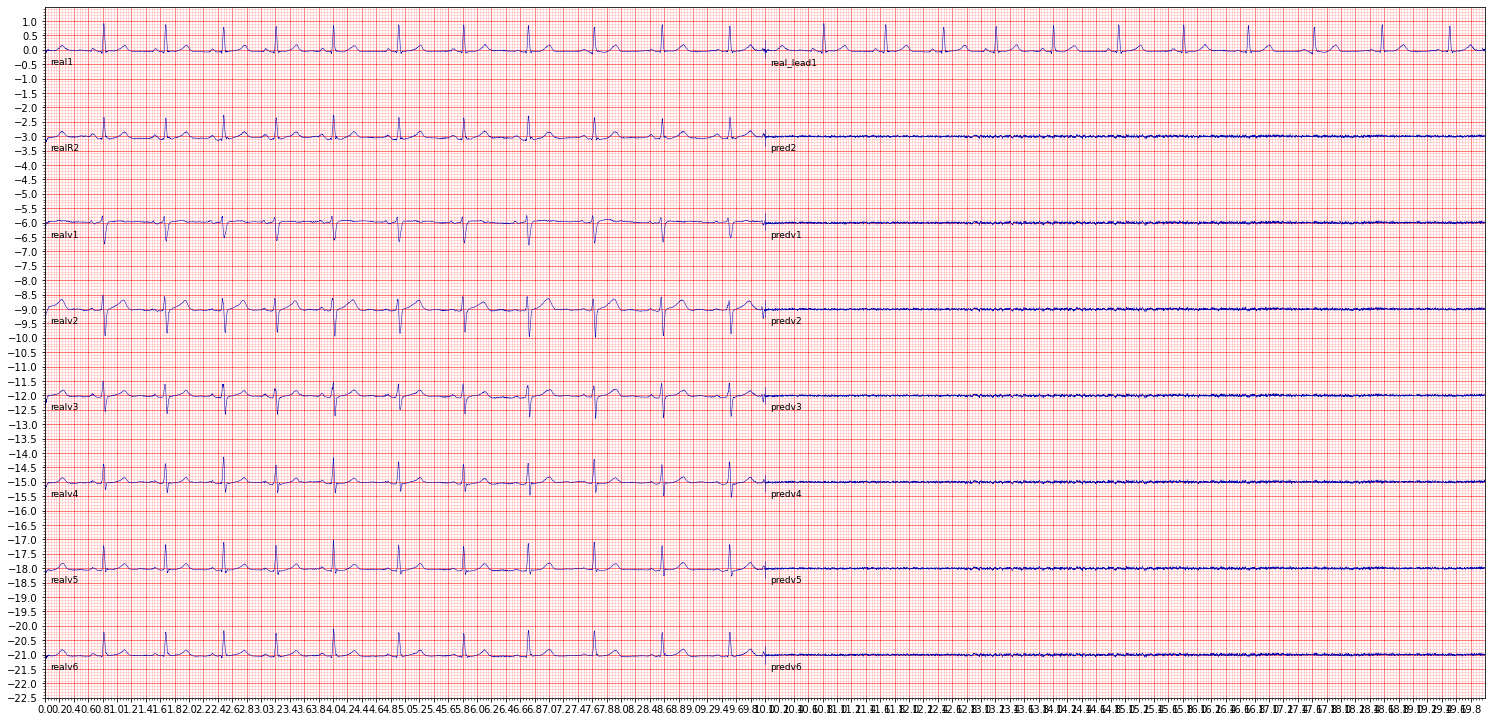

In [56]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

In [ ]:
model
